In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1p_cXzuANvWhSJ83hSfQzUUBu2KBdgbzc

import pandas as pd
import numpy as np

df = pd.read_csv("weather_prediction_dataset.csv")

Downloading...
From: https://drive.google.com/uc?id=1p_cXzuANvWhSJ83hSfQzUUBu2KBdgbzc
To: /content/weather_prediction_dataset.csv
100% 2.77M/2.77M [00:00<00:00, 74.2MB/s]


In [ ]:
france_cities = ["TOURS"]

columns_to_keep = ["DATE", "MONTH"] + [col for col in df.columns if any(city in col for city in france_cities)]
df_france = df[columns_to_keep]

df_france.to_csv("weather_prediction_dataset_france.csv", index=False)

print("Filtered dataset saved as 'weather_prediction_dataset_france.csv'")

Filtered dataset saved as 'weather_prediction_dataset_france.csv'


In [ ]:
from google.colab import files

# Download the filtered dataset
# files.download("weather_prediction_dataset_france.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

file_path = "weather_prediction_dataset_france.csv"
df = pd.read_csv(file_path)

df.fillna(df.mean(), inplace=True)

relevant_features = ["DATE", "MONTH", "TOURS_temp_mean", "TOURS_humidity",
                     "TOURS_pressure", "TOURS_wind_speed"]
df_selected = df[relevant_features]

scaler = MinMaxScaler()
df_scaled = df_selected.copy()
df_scaled.iloc[:, 2:] = scaler.fit_transform(df_selected.iloc[:, 2:])

df_scaled.to_csv("weather_prediction_dataset_france_final.csv", index=False)

print("Preprocessing completed! Saved:")
print("- 'weather_prediction_dataset_france_final.csv' (scaled data)")

Preprocessing completed! Saved:
- 'weather_prediction_dataset_france_final.csv' (scaled data)


In [ ]:
# Download the preprocessed dataset
# files.download("weather_prediction_dataset_france_final.csv")


In [ ]:
import pandas as pd
import numpy as np

# Load final preprocessed dataset
df = pd.read_csv("weather_prediction_dataset_france_final.csv")

# Add YEAR column from DATE
df["YEAR"] = df["DATE"].astype(str).str[:4].astype(int)

# Drop DATE and MONTH for modeling
features = df.drop(columns=["DATE", "MONTH", "YEAR"]).values
years = df["YEAR"].values

# Set parameters
window_size = 5
overlap = 4
stride = window_size - overlap  # you can also set this manually

# Updated function: test set generation (strict)
def create_sequences_strict(data, years, window_size, stride, year_filter):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        window_years = years[i:i + window_size + 1]
        if not np.all(window_years == year_filter):
            continue
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Updated function: training data generation (excluding 2009)
def create_sequences(data, years, window_size, stride, target_year=None):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        if target_year is not None and years[i + window_size] != target_year:
            continue
        if target_year is None and years[i + window_size] == 2009:
            continue
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Create test and train sets
X_test, y_test = create_sequences_strict(features, years, window_size, stride, year_filter=2009)
X_train, y_train = create_sequences(features, years, window_size, stride, target_year=None)

# Print shapes
print("✅ Data Prepared")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


✅ Data Prepared
X_train shape: (3284, 5, 4)
y_train shape: (3284, 4)
X_test shape: (360, 5, 4)
y_test shape: (360, 4)


In [ ]:
#MLR

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make sure your X_train, X_test, y_train, y_test are already loaded and shaped like:
# X_train: (3284, 5, 4)
# y_train: (3284, 4)
# X_test:  (360, 5, 4)
# y_test:  (360, 4)

# Flatten the input: (samples, 5, 4) → (samples, 20)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize and train the Multiple Linear Regression model
mlr = LinearRegression()
mlr.fit(X_train_flat, y_train)

# Predict on the test set
y_pred = mlr.predict(X_test_flat)

# Evaluate using MSE, MAE, RMSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print("✅ MLR Evaluation Results:")
print(f"MSE  = {mse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


✅ MLR Evaluation Results:
MSE  = 0.0077
MAE  = 0.0592
RMSE = 0.0879


In [ ]:
#MPR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Flatten input (5 days × 4 features = 20 features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Step 2: Polynomial expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_flat)
X_test_poly = poly.transform(X_test_flat)

# Step 3: Ridge Regression (α = 0.0001)
mpr = Ridge(alpha=0.0001)
mpr.fit(X_train_poly, y_train)

# Step 4: Predict
y_pred = mpr.predict(X_test_poly)

# Step 5: Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Step 6: Output results
print("✅ MPR (degree=2, alpha=0.0001) Evaluation Results:")
print(f"MSE  = {mse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


✅ MPR (degree=2, alpha=0.0001) Evaluation Results:
MSE  = 0.0077
MAE  = 0.0587
RMSE = 0.0878


In [ ]:
#KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assumes X_train, X_test, y_train, y_test already defined:
# X_train: (3284, 5, 4)
# X_test:  (360, 5, 4)
# y_train: (3284, 4)
# y_test:  (360, 4)

# Step 1: Flatten input: (samples, 5, 4) → (samples, 20)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Step 2: Define and fit KNN model with k = 3 and Euclidean distance (default)
knn = KNeighborsRegressor(n_neighbors=3, metric='euclidean')
knn.fit(X_train_flat, y_train)

# Step 3: Predict
y_pred = knn.predict(X_test_flat)

# Step 4: Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Step 5: Output results
print("✅ KNN Regression (k=3, Euclidean) Evaluation Results:")
print(f"MSE  = {mse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


✅ KNN Regression (k=3, Euclidean) Evaluation Results:
MSE  = 0.0113
MAE  = 0.0710
RMSE = 0.1061


In [ ]:
#MLP
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

# Assumes X_train, y_train, X_test, y_test are already defined
# Flatten inputs
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define the model
model = Sequential([
    Input(shape=(X_train_flat.shape[1],)),
    Dense(128, activation='sigmoid', kernel_regularizer=l2(0.0001)),
    Dense(64, activation='sigmoid', kernel_regularizer=l2(0.0001)),
    Dense(4, kernel_regularizer=l2(0.0001))  # Output layer for 4 target values
])

# Compile the model with SGD optimizer (momentum + learning rate)
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(X_train_flat, y_train, epochs=1000, batch_size=32, verbose=1)

# Predict on test set
y_pred = model.predict(X_test_flat)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation
print("✅ MLP (Sigmoid, Momentum, L2) Evaluation Results:")
print(f"MSE  = {mse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


Epoch 1/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0730
Epoch 2/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330
Epoch 3/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334
Epoch 4/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327
Epoch 5/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0322
Epoch 6/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316
Epoch 7/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311
Epoch 8/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313
Epoch 9/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300
Epoch 10/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298
Epoch 11/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297
Epoch 12/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295
Epoch 13/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292
Epoch 14/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285
Epoch 15/1000
103/103 ━━━━━━━

In [ ]:
#CNN
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

# Ensure the shape is (samples, 5, 4) for CNN
X_train_cnn = X_train.reshape(-1, 5, 4)
X_test_cnn = X_test.reshape(-1, 5, 4)


model = Sequential([
    Input(shape=(5, 4)),  # (timesteps=5, features=4)
    Conv1D(filters=32, kernel_size=2, activation='tanh', kernel_regularizer=l2(0.0001)),
    Flatten(),
    Dense(64, activation='tanh', kernel_regularizer=l2(0.0001)),
    Dense(4, kernel_regularizer=l2(0.0001))
])

# Compile
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='mse')

# Fit
model.fit(X_train_cnn, y_train, epochs=1000, batch_size=32, verbose=1)

# Predict
y_pred = model.predict(X_test_cnn)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print("✅ CNN (tanh, L2, Momentum) Evaluation Results:")
print(f"MSE  = {mse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


Epoch 1/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0755
Epoch 2/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215
Epoch 3/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207
Epoch 4/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0196
Epoch 5/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196
Epoch 6/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 7/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 8/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 9/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190
Epoch 10/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183
Epoch 11/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 12/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 13/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182
Epoch 14/1000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 15/1000
103/103 ━━━━━━━

Training Progress: 100%|███████| 200/200 [01:04<00:00,  3.10it/s, Train MSE=0.6685, Test MSE=0.6354]


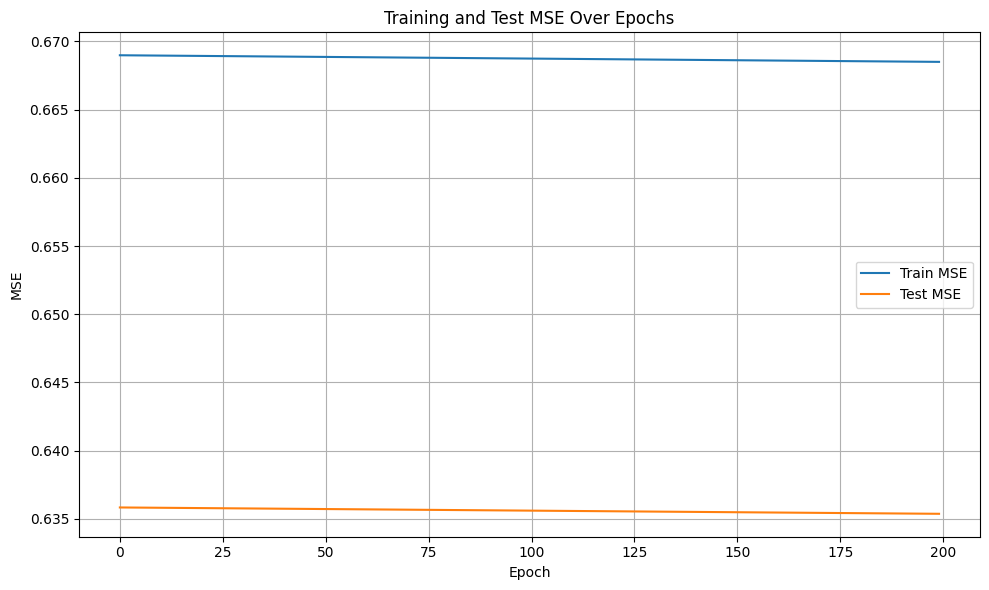

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

# Flatten input if needed
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Loop over different learning rates


# Custom callback to log and print training/test MSE at each epoch
class TrainingLogger(Callback):
    def on_train_begin(self, logs=None):
        self.train_errors = []
        self.test_errors = []
        self.pbar = tqdm(total=self.params['epochs'], desc="Training Progress", ncols=100)

    def on_epoch_end(self, epoch, logs=None):
        y_pred_test = self.model.predict(X_test_flat, verbose=0)
        test_mse = mean_squared_error(y_test, y_pred_test)

        self.train_errors.append(logs["loss"])
        self.test_errors.append(test_mse)

        self.pbar.set_postfix({"Train MSE": f"{logs['loss']:.4f}", "Test MSE": f"{test_mse:.4f}"})
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

# Build model
model = Sequential([
    Input(shape=(X_train_flat.shape[1],)),
    Dense(64, activation='relu'),    # Hidden Layer
    Dense(y_train.shape[1], activation='linear')  # Output Layer
])

# Compile with SGD and MSE
optimizer = SGD(learning_rate=0.00000001)
model.compile(optimizer=optimizer, loss='mse')

# Train model with callback
logger = TrainingLogger()
model.fit(X_train_flat, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[logger])

# Plot training and test MSE
plt.figure(figsize=(10, 6))
plt.plot(logger.train_errors, label='Train MSE')
plt.plot(logger.test_errors, label='Test MSE')
plt.title("Training and Test MSE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("y_train shape:", y_train.shape)
print("Number of output features:", y_train.shape[1])


y_train shape: (3284, 4)
Number of output features: 4


Training Progress: 100%|███████| 200/200 [01:21<00:00,  2.45it/s, Train MSE=0.0103, Test MSE=0.0096]


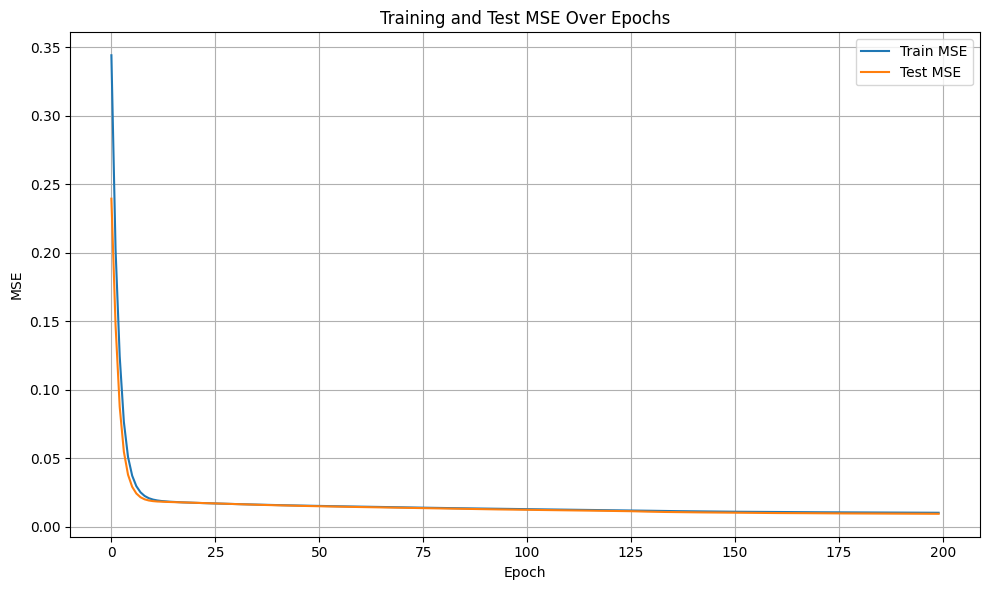

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

# Flatten input if needed
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Loop over different learning rates


# Custom callback to log and print training/test MSE at each epoch
class TrainingLogger(Callback):
    def on_train_begin(self, logs=None):
        self.train_errors = []
        self.test_errors = []
        self.pbar = tqdm(total=self.params['epochs'], desc="Training Progress", ncols=100)

    def on_epoch_end(self, epoch, logs=None):
        y_pred_test = self.model.predict(X_test_flat, verbose=0)
        test_mse = mean_squared_error(y_test, y_pred_test)

        self.train_errors.append(logs["loss"])
        self.test_errors.append(test_mse)

        self.pbar.set_postfix({"Train MSE": f"{logs['loss']:.4f}", "Test MSE": f"{test_mse:.4f}"})
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

# Build deeper model
model = Sequential([
    Input(shape=(X_train_flat.shape[1],)),
    Dense(256, activation='relu'),     # 1st hidden layer
    Dense(128, activation='relu'),     # 2nd hidden layer
    Dense(64, activation='relu'),      # 3rd hidden layer (original size)
    Dense(32, activation='relu'),      # 4th hidden layer
    Dense(y_train.shape[1], activation='linear')  # Output layer
])


# Compile with SGD and MSE
optimizer = SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train model with callback
logger = TrainingLogger()
model.fit(X_train_flat, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[logger])

# Plot training and test MSE
plt.figure(figsize=(10, 6))
plt.plot(logger.train_errors, label='Train MSE')
plt.plot(logger.test_errors, label='Test MSE')
plt.title("Training and Test MSE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training Progress: 100%|███████| 200/200 [01:37<00:00,  2.06it/s, Train MSE=0.5053, Test MSE=0.4846]


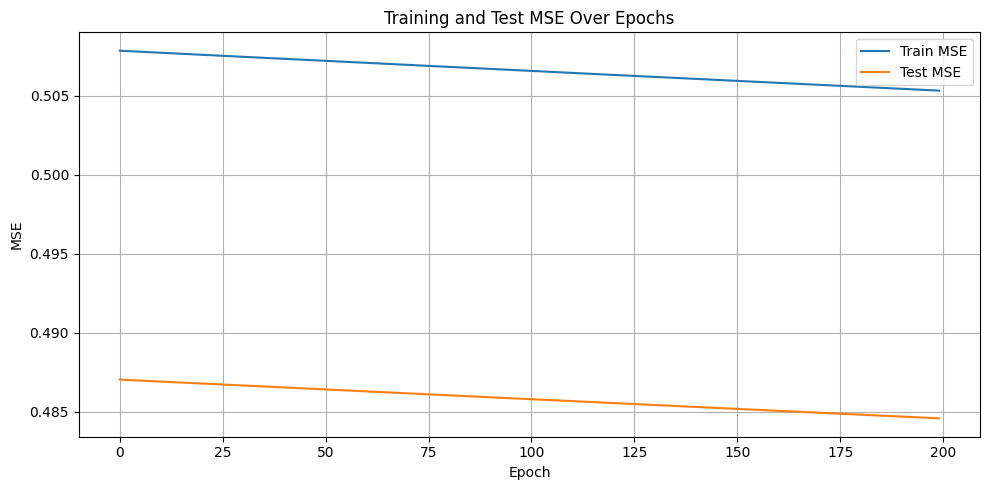

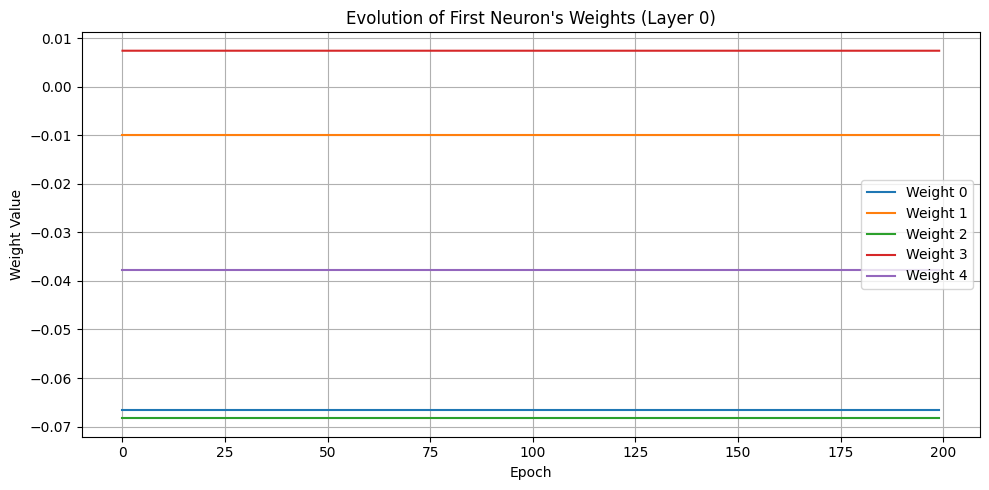

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

# 1. آماده‌سازی داده‌ها
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 2. لاگر برای ثبت MSE آموزش و تست
class TrainingLogger(Callback):
    def on_train_begin(self, logs=None):
        self.train_errors = []
        self.test_errors = []
        self.pbar = tqdm(total=self.params['epochs'], desc="Training Progress", ncols=100)

    def on_epoch_end(self, epoch, logs=None):
        y_pred_test = self.model.predict(X_test_flat, verbose=0)
        test_mse = mean_squared_error(y_test, y_pred_test)
        self.train_errors.append(logs["loss"])
        self.test_errors.append(test_mse)
        self.pbar.set_postfix({"Train MSE": f"{logs['loss']:.4f}", "Test MSE": f"{test_mse:.4f}"})
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

class WeightTracker(Callback):
    def __init__(self, layer_index=1, neuron_index=0):
        super().__init__()
        self.layer_index = layer_index
        self.neuron_index = neuron_index
        self.weights_over_time = []

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.layers[self.layer_index].get_weights()[0]
        neuron_weights = weights[:, self.neuron_index]
        self.weights_over_time.append(neuron_weights.copy())

# 4. ساخت مدل عمیق
model = Sequential([
    Input(shape=(X_train_flat.shape[1],)),
    Dense(256, activation='relu'),  # layer_index = 0
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='linear')
])

# 5. کامپایل مدل با SGD و پارامترهای خواسته‌شده
optimizer = SGD(learning_rate=0.00000001, momentum=0.9)
model.compile(optimizer=optimizer, loss='mse')

# 6. شروع آموزش همراه با کالبک‌ها
logger = TrainingLogger()
tracker = WeightTracker(layer_index=1, neuron_index=0)  # نورون ۰ از لایه Dense اول

model.fit(X_train_flat, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[logger, tracker])

# 7. رسم خطای آموزش و تست
plt.figure(figsize=(10, 5))
plt.plot(logger.train_errors, label='Train MSE')
plt.plot(logger.test_errors, label='Test MSE')
plt.title("Training and Test MSE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. رسم تغییرات وزن‌های نورون انتخاب‌شده
weights_array = np.array(tracker.weights_over_time)  # شکل: (epochs, input_dim)

plt.figure(figsize=(10, 5))
for i in range(min(5, weights_array.shape[1])):  # رسم ۵ وزن اول نورون ۰
    plt.plot(weights_array[:, i], label=f'Weight {i}')
plt.title("Evolution of First Neuron's Weights (Layer 0)")
plt.xlabel("Epoch")
plt.ylabel("Weight Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


